<a href="https://colab.research.google.com/github/ElenaBetelgeuse/Automatic-segmentation-of-brain-tumors-using-UNET/blob/main/%D0%A3%D0%BB%D1%83%D1%87%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# # sns.set_style(style='whitegrid')
# device_num = 0
# torch.cuda.set_device(device_num)

### Загрузим датасет

На занятии мы познакомимся с датасетом Симпсонов! Там собраны знакомые многим персонажи знаменитого мультфильма для решения задачи классификации.

In [ ]:
# загрузим датасет со своего Google Drive

# предварительно скачаем датасет с kaggle: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset
# создаём zip-архивы из папок simpsons_dataset и kaggle_simpson_testset
# и загружаем на свой google drive в папку DATA/SIMPSONS

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!mkdir -p data

!cp drive/MyDrive/DATA/SIMPSONS/test.zip data/
!cp drive/MyDrive/DATA/SIMPSONS/train.zip data/

!unzip -o -qq data/test.zip -d data/
!unzip -o -qq data/train.zip -d data/
!rm -rf data/simpsons_dataset/simpsons_dataset

Все данные теперь находятся в папке `data`.

Тестовые данные (`kaggle_simpson_testset/`) сегодня не пригодятся.

Структура трейн данных (`simpsons_dataset/`) следующая:


 \\
-- class_name_0 \\
---- img_0 \\
---- img_1 \\
---- ... \\
---- img_n \\
... \\
-- class_name_k \\
---- img_0 \\
---- img_1 \\
---- ... \\
---- img_m \\


Т.е. название папки -- имя класса (персонажа из Симпсонов), изображения в ней относятся к этому классу.

In [ ]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "data/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


В случае описанного выше строения хранящихся данных для создания датасета очень удобен `ImageFolder`.

Хоть авторы библиотеки это и не задумывали, но аргумент `is_valid_file` нам пригодился для разбиения на `train` и `val`.

In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [ ]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


Посмотрим на изображения из `val` и `train`

In [ ]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

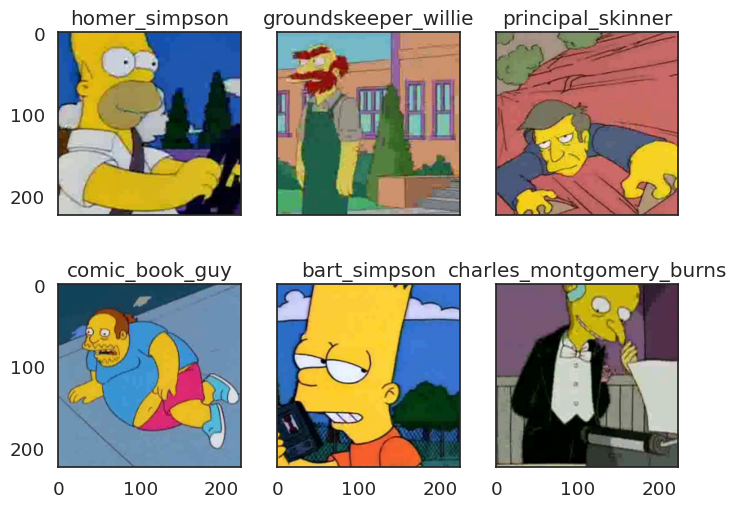

In [ ]:
show_images(val_dataset)

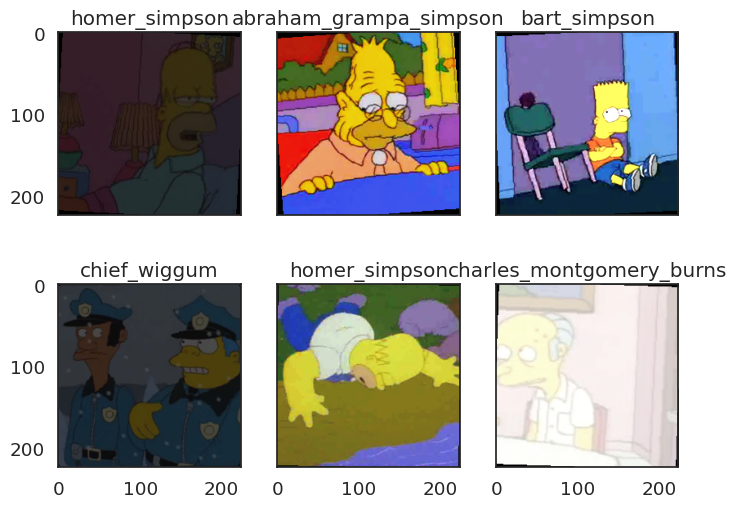

In [ ]:
show_images(train_dataset)

Невооруженным взглядом видно, что картинки из `train` выглядят немного изменёнными по сравнению с `val`. Опишем по пунктам, почему так происходит.

1. К `train` применялись дополнительные аугментации `ColorJitter` и `RandomAffine`, чтобы увеличить размер датасета и обобщающую способность сети.
2. К `val` никакие меняющие изображение аугментации не применялись, т.к. замерять метрику качества необходимо на настоящих данных.

**Создадим DataLoader-ы и функции для обучения**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
from torchvision.models import resnet18

Будем использовать как `FineTuning` (обучение без использования scheduls)

Epoch 10 of 10 took 167.890s
  training loss (in-iteration): 	0.092149
  validation loss (in-iteration): 	0.211458
  training accuracy: 			97.82 %
  validation accuracy: 			95.09 %


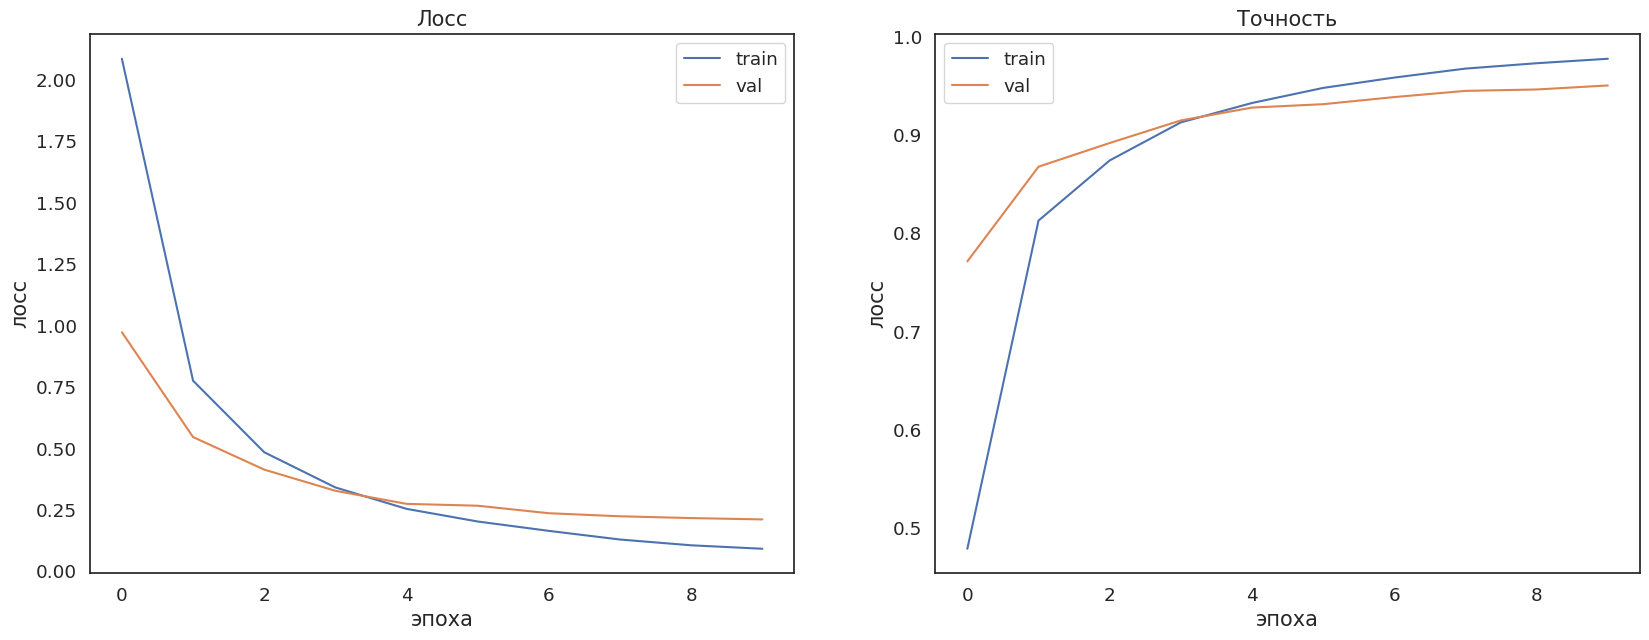

In [ ]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Создадим новую функцию для экспериментов с Learning Schedulers

In [ ]:
def train_sch(
    model,
    criterion,
    optimizer,
    scheduler,  # допишем сюда scheduler
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            scheduler.step(loss) # допишем сюда scheduler
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
import torch.optim.lr_scheduler as sch # скачаем schedulers из torch

In [ ]:
scheduler = sch.ExponentialLR(optimizer, gamma=0.9) # сначала попробуем поэкспериментировать с ExponentialLR

Epoch 10 of 10 took 166.136s
  training loss (in-iteration): 	0.092930
  validation loss (in-iteration): 	0.214021
  training accuracy: 			97.67 %
  validation accuracy: 			95.31 %


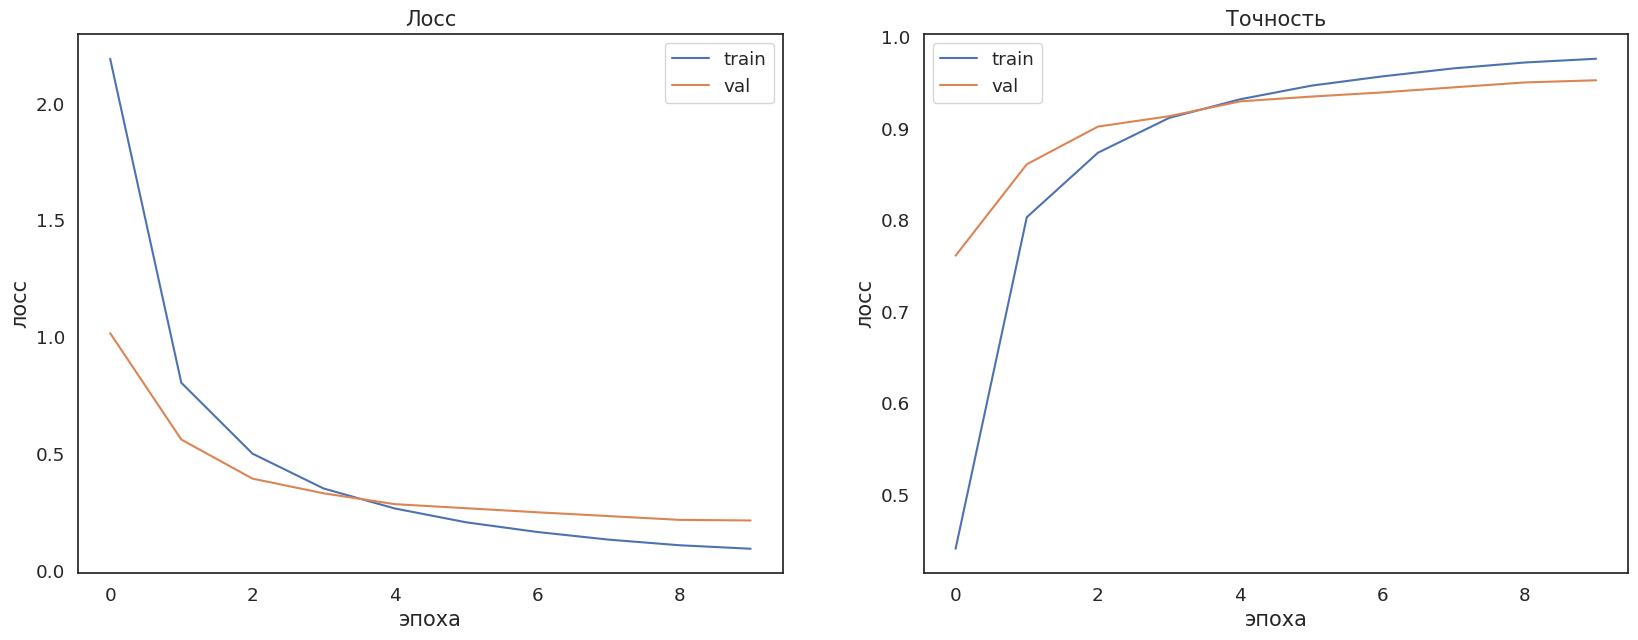

In [ ]:
# заново обучим ту же самую модель уже встроив в функцию обучения ExponentialLR
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train_sch(
    fine_tuning_model, criterion, optimizer, scheduler,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)
# качество немного улучшилось по сравнению с предыдущим

In [ ]:
scheduler = sch.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1) # второй эксперимент проведём с MultiStepLR

Epoch 10 of 10 took 170.926s
  training loss (in-iteration): 	0.085476
  validation loss (in-iteration): 	0.208050
  training accuracy: 			97.95 %
  validation accuracy: 			95.01 %


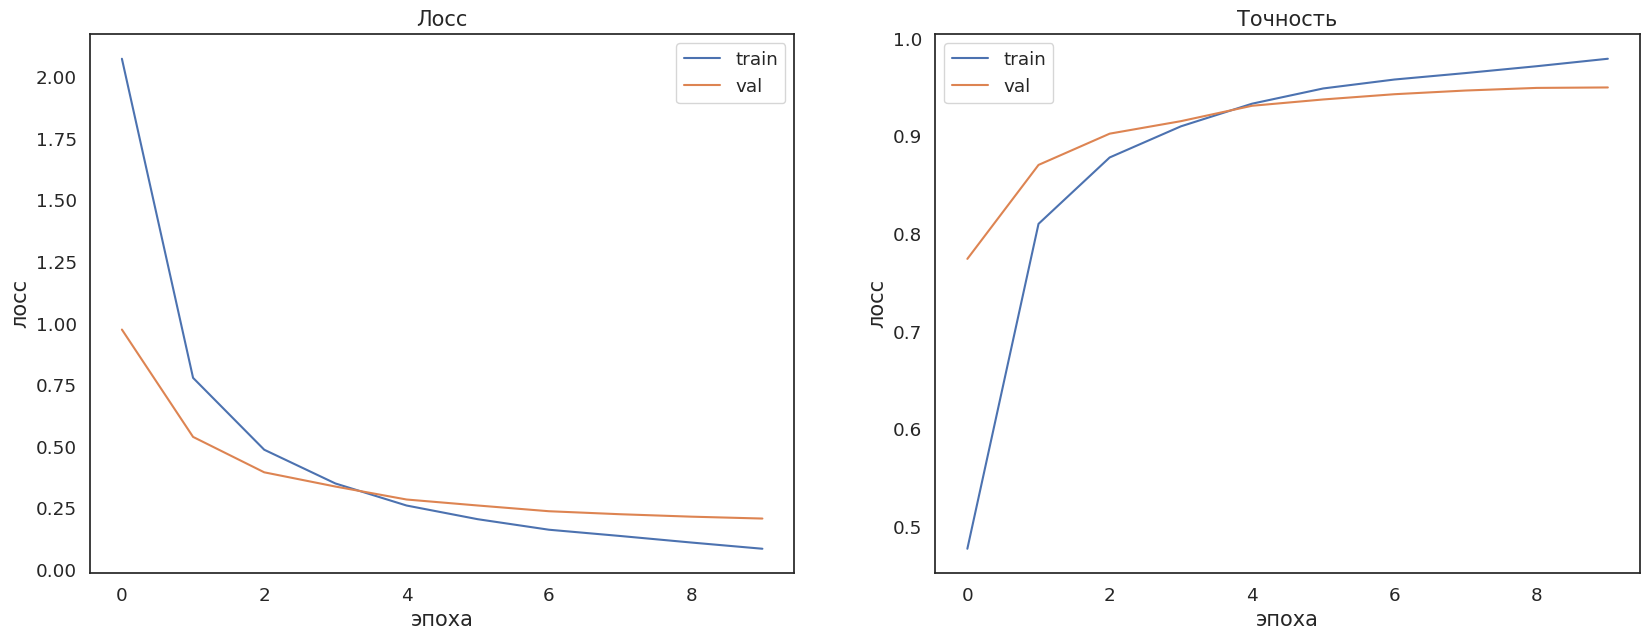

In [ ]:
# заново обучим ту же самую модель уже встроив в функцию обучения MultiStepLR
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train_sch(
    fine_tuning_model, criterion, optimizer, scheduler,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)
# Здесь видер, что качество снова упало и стало хуже, чем в самом первом случае буз использования schedulers

ТЕПЕРЬ ПОЭКСПЕРИМЕНТИРУЕМ С АУГМЕНТАЦИЕЙ

In [ ]:
# доводим трейновые изображения до состояния "change beyond recognition"
input_size = 28

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomVerticalFlip(p=0.9), # пусть будет рандомный (90%) вертикальный флип
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(5.0, 5.0, 5.0), # пусть будет такое огромное значение измененя яркости изображений
    transforms.RandomAffine(50), # пусть будет такое огромное значение аффинного преобразования
    transforms.ToTensor(),
])

In [ ]:
# изменим трейновый датасет с учётом новой аугментации
train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

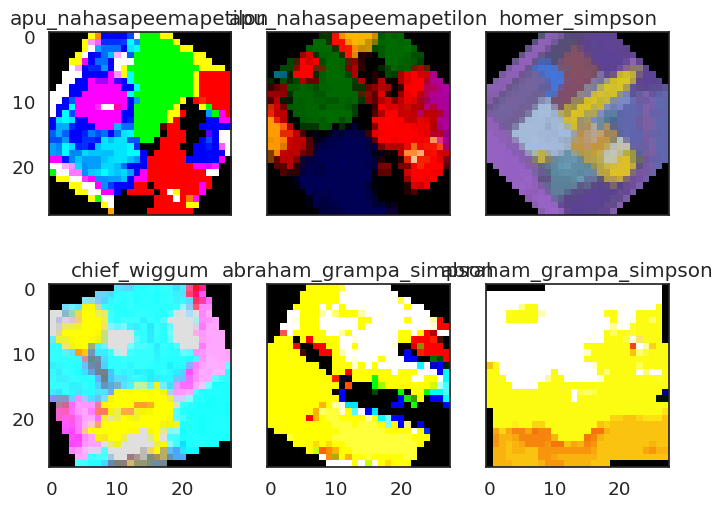

In [ ]:
# видно, что напакостить с изображениями очень удалось, и, видно, что это аффинное преобразование так сработало
show_images(train_dataset)

In [ ]:
# Заново зададим train_batch_gen и val_batch_gen для подачи данных в модель
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

Epoch 10 of 10 took 96.169s
  training loss (in-iteration): 	2.343245
  validation loss (in-iteration): 	3.375146
  training accuracy: 			34.74 %
  validation accuracy: 			7.26 %


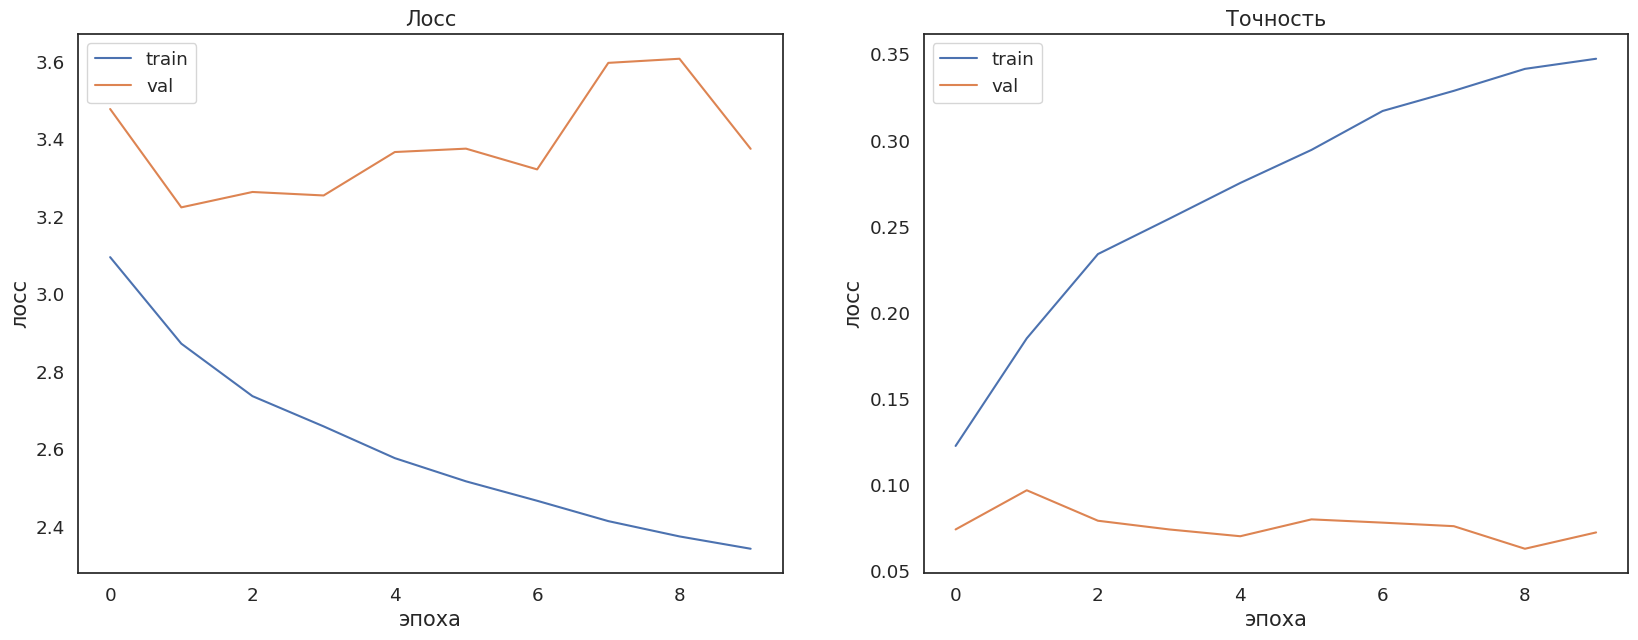

In [ ]:
# заново обучим модель
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)
# из-за новых настроек аугментации качество на валидационной выборке упало с 95% до 7%

В целях экономии вычислительных ресурсов возьмём модель поменьше - MOBILENET

In [ ]:
# Снова вернёмся к первичному неиспорченному аугментацией трейновому датасету
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

In [ ]:
# заново зададим train_batch_gen и val_batch_gen для подачи данных в модель
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
from torchvision.models import mobilenet_v2

In [ ]:
mobile_model = mobilenet_v2(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(mobile_model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
scheduler = sch.ReduceLROnPlateau(optimizer, 'min') # попробуем третий scheduler

Epoch 10 of 10 took 187.765s
  training loss (in-iteration): 	0.076864
  validation loss (in-iteration): 	0.217071
  training accuracy: 			97.79 %
  validation accuracy: 			95.31 %


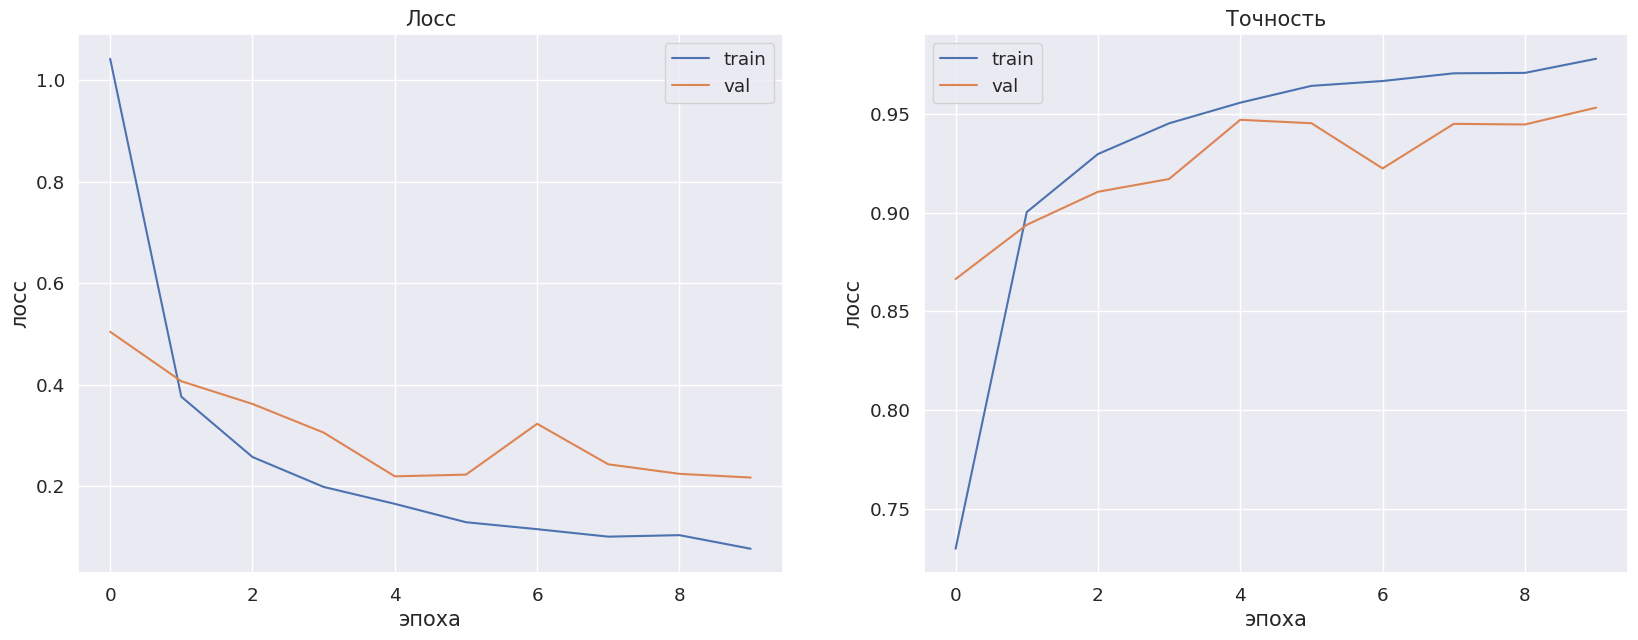

In [ ]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('mobilenet_v2', mobilenet_v2(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.1)

clf_model, history = train_sch(
    fine_tuning_model, criterion, optimizer, scheduler,
    train_batch_gen, val_batch_gen,
    num_epochs=10)

ВЫВОДЫ:

1) В работе были выполены два опыта с schedulers (ExponentialLR и MultiStepLR). При использовании ExponentialLR accuracy немного выросла. Но это могло произойти и из-за различного перемешивания обучающей выпорки в батчах. Использование MultiStepLR показало незначительное снижение качества, что также могло произойти по причине различного перемешивания.

2) Удалось достичь существенного понижения качества при насторйке параметров аугментации. Самую большую роль здесь сыграло аффинное преобразование трейновой выборки.

3) При использовании предобученной MobileNet (на примере дообучения предобученной ResNet18, рассмотренном на занятии) с использованием scheduler ReduceLROnPlateau удалось получить достаточно высокое качество на валидационной выборке 95,31%.
